# Forward inverse rendering

## Overview

The previous example demonstrated *reverse-mode differentiation* (a.k.a. backpropagation) where a desired small change to the output image was converted into a small change to the scene parameters. Mitsuba and Dr.Jit can also propagate derivatives in the other direction, i.e., from input parameters to the output image. This technique, known as *forward mode differentiation*, is typically less suitable for optimization, as the contribution from each parameter must be handled using a separate rendering pass. That said, this mode can be very educational since it enables visualizations of the effect of individual scene parameters on the rendered image.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**
    
<ul>
  <li>Manually set scene parameters as differentiable</li>
  <li>Perform forward-mode differentiation with Dr.Jit</li>
  <li>Visualize gradient images with <code>matplotlib</code></li>
</ul>
    
</div>

## Setup

We start by setting an AD-compatible variant (here `llvm_ad_rgb`) and load the Cornell Box scene.

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

scene = mi.load_file('../scenes/cbox.xml')

## Preparing the scene

Forward mode differentiable rendering begins analogously to reverse mode, by marking the parameters of interest as differentiable (in this example, we do so manually instead of using an `Optimizer`). 

Our goal here is to visualize how changes of the green wall's color affect the final rendered image. Note that we are rendering this image using a physically-based *path tracer*, which means that it accounts for globlal illumination, reflection, refraction, and so on. Gradients computated from this simulation will also expose such effects.

In [2]:
params = mi.traverse(scene)

key = 'green.reflectance.value'

# Mark the green wall color parameter as differentiable
dr.enable_grad(params[key])

# Propagate this change to the scene internal state
params.update();

## Rendering

We can then perform the simulation to be differentiated. In this case, we simply render an image using the `mi.render()` routine, which will in turn call the scene's path tracer integrator.

As we have marked the wall color as *differentiable*, its role in the rendering process is recorded in the autodiff graph.

In [3]:
image = mi.render(scene, params, spp=128)

The [<code>dr.forward()</code>][1] function will assign a gradient value of `1.0` to the given variables and forward-propagate those gradients through the previously recorded computation graph. During this process, gradient will be accumulated in the output nodes of this graph (here, the rendered image).
Finally, the gradients can be read using [<code>dr.grad()</code>][2].

For more detailed information about differentiation with DrJit, please refer to the [documentation][3].

[1]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.forward
[2]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.grad
[3]: https://drjit.readthedocs.io/en/latest

In [4]:
# Forward-propagate gradients through the computation graph
dr.forward(params[key])

# Fetch the image gradient values
grad_image = dr.grad(image)

## Visualizing the gradient image

The gradient value of the `image` variable will share the same type (here `TensorXf`) hence it can easily be visualized as any other image.
When displayin the gradient image below, we boost the gain a bit to better see the *global effect* of the wall color on the rest of the scene.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


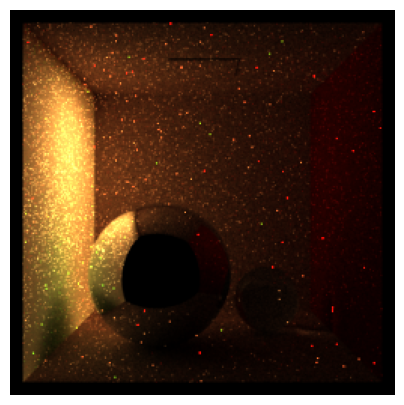

In [5]:
import matplotlib.pyplot as plt
plt.imshow(grad_image * 2.0)
plt.axis('off');

Note however that gradient values are not necessarily within the `[0, 1]` range, and so it makes more sense to use a color map and visualize each color channel of the gradient image individually.

Remapping colors within range: [-2.79, 2.79]


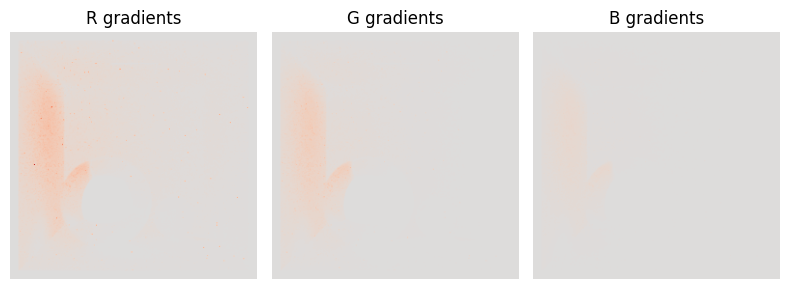

In [6]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

cmap = cm.coolwarm
vlim = dr.max(dr.abs(grad_image).array)[0]
print(f'Remapping colors within range: [{-vlim:.2f}, {vlim:.2f}]')

fig, axx = plt.subplots(1, 3, figsize=(8, 3))
for i, ax in enumerate(axx):
    ax.imshow(grad_image[..., i], cmap=cm.coolwarm, vmin=-vlim, vmax=vlim)
    ax.set_title('RGB'[i] + ' gradients')
    ax.axis('off')
fig.tight_layout()
plt.show()

## Using latent variables (advanced)

In more complex scenarios, scene parameters might themselves be the result of differentiable computations, then depending on other *latent variables*. For instance, the color of the CBox wall could be the result of the evalutation of a neural network, or some other procedural process.

In this case, it is important for the gradients of those latent variables to be propagate to the scene parameters **before** calling `mi.render()`. This way, the computation happing inside the renderer will only be responsible for propagating the gradients further to the output image. Failing to do so will result in uncorrect gradient as the loop tracing will destroy the part of the computational graph that took place outside of the loop (e.g. here linking the latent variable to the scene parameters).

In this example, we are simply going to parameterize the wall color using simple arithmetics and forward propagate the gradients properly.

In [7]:
# Our latent variable
theta = mi.Float(0.5)
dr.enable_grad(theta)

# The wall color now depends on `theta`
params[key] = mi.Color3f(
    0.2 * theta,
    0.5 * theta,
    0.8 * theta
)

# Propagate this change to the scene internal state
params.update();

Dr.Jit exposes various [<code>dr.ADFlag</code>][1] flags to control how the AD graph should be affected by the AD traversal. [<code>dr.ADFlag.ClearEdges</code>][2] specifies that gradient values should be kept in all variables during the traversal. This is to handle the case where a scene parameter depends on another scene parameter. Without this flag, the first scene parameter wouldn't be considered as a *leaf* node during the traversal and its gradient would be set to zero instead.

The following line propagates gradients from `theta` to the 3 channels of the `green.reflectance.value` scene parameters.

[1]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.traverse
[2]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.traverse

In [8]:
dr.forward(theta, dr.ADFlag.ClearEdges)

As done before, we can now render the image and forward progate the gradients from the scene parameters to the output image.

Unfortunately `dr.forward()` will overwrite the gradients of the provided variable, so it is necessary to use a different function in this situation. [<code>dr.forward_to()</code>][1] automatically propagates gradients to a specified variable after finding all possible sources by inspecting the AD graph. It does so without overwritting the gradient value in those which is what we need in this context.

[1]: https://drjit.readthedocs.io/en/latest/reference.html#drjit.forward

In [9]:
image = mi.render(scene, params, spp=128)

# Forward-propagate the gradients to the image
dr.forward_to(image)

# Visualize the gradient image
mi.Bitmap(dr.grad(image))

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

## See also

- [<code>mitsuba.ad.Optimizer</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Optimizer)
- [<code>prb</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#path-replay-backpropagation-prb)
- [<code>drjit.forward()</code>](https://drjit.readthedocs.io/en/latest/reference.html#drjit.forward)
- [<code>drjit.forward_to()</code>](https://drjit.readthedocs.io/en/latest/reference.html#drjit.forward_to)